In [1]:
import numpy as np
import pandas as pd
from geopy.geocoders import Nominatim
from sklearn.covariance import GraphicalLasso
import sklearn
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from scipy import stats

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [2]:
df=pd.read_pickle("./cleanData_model.pkl")

# Preparing HVI Data

In [58]:
target='SALEPRICE'
numerical=[
            # 'lng-zip',
            # 'lat-zip',
            # 'LOTAREA',
            'saledate-int',
            # 'prevsaledate-int',
            # 'prevsaledate2-int',
            # 'PREVSALEPRICE',
            # 'PREVSALEPRICE2',
            'FINISHEDLIVINGAREA',
            # 'STORIES',
            'YEARBLT',
            'CARDNUMBER',
            'BSMTGARAGE',
            'FIREPLACES',
            'HALFBATHS',
            'FULLBATHS',
            'TOTALROOMS'
            ]
categorical=[
            # 'SCHOOLCODE',
            # 'TAXCODE',
            # 'TAXSUBCODE',
            'OWNERCODE',
            'CLASS',
            'ROOF',
            'BASEMENT',
            # 'LOCALLAND',
            'FAIRMARKETBUILDING',
            'FAIRMARKETLAND',
            'STYLE',
            'ROOF',
            'BASEMENT',
            'GRADE',
            'CONDITION',
            # 'HEATINGCOOLING',
            'PARID',
            'MUNICODE',
            'USECODE',
            # 'HOMESTEADFLAG',
            # 'FARMSTEADFLAG',
            'CLEANGREEN',
            # 'ABATEMENTFLAG',
            'SALECODE',
            'COUNTYBUILDING',
            'COUNTYLAND',
            'EXTERIORFINISH',
            # 'CDU'
            ]

In [59]:
df_sample=df

X=df_sample[numerical+categorical]
y=df_sample[target]


from sklearn import preprocessing
from sklearn.model_selection import train_test_split
scaler = preprocessing.StandardScaler().fit(X)
X['saledate-int']=X['saledate-int']*5
X_scaled = scaler.transform(X)

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


# Training Model

In [60]:
import xgboost as xg 
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score 


# Instantiation 
xgb_r = xg.XGBRegressor(objective ='reg:squarederror', 
                  n_estimators = 110, seed = 10) 
  
# Fitting the model 
xgb_r.fit(X_scaled, y);
pickle.dump(xgb_r, open('models/XGB2.pkl', 'wb'))

In [61]:
xgb_r.score(X_scaled, y)

0.8673892929246007

# Creating HVI Analysis

In [62]:
X_props=X.groupby('PARID').mean()
X_props['PARID']=X_props.index

In [63]:
#FIGURING OUT HOW TO SPACE OUT THE DATES TO QUERY ONCE PER MONTH

print(min(df['SALEDATE']))
print(max(df['SALEDATE']))
print((2020-1871)*12+2)

XDates=np.linspace(min(df['SALEDATE']).value,max(df['SALEDATE']).value,1790)
XDates=pd.to_datetime(XDates)
XDatesInt=mdates.date2num(XDates)

1870-11-12 00:00:00
2021-01-25 00:00:00
1790


In [64]:
xgb_r = pickle.load(open('models/XGB2.pkl', 'rb'))

In [144]:
def computeAppreciation(y_new,y_old,y_consider):
    y_old_sum=np.sum(y_old)
    appr=0
    for j in y_consider:
        a=(y_new[j]-y_old[j])/y_old[j]
        w_old=y_new[j]/y_old_sum

        appr+=a*w_old
    return appr

X_props=X.groupby('PARID').mean() #group by properties
X_props['PARID']=X_props.index #add index back into dataset

appretiation={}
y_old=[]
for i in range(0,len(XDates),1):
    X_props['saledate-int']=XDatesInt[i]*5 #update the saledate for existing properties
    X_props_scaled = scaler.transform(X_props) #standardize values based on previous information
    y_new=xgb_r.predict(X_props_scaled)
    y_consider=np.where(X_props['YEARBLT'].le(XDates[i].year))[0]

    try:
        apr=appretiation[XDates[i]]=computeAppreciation(y_new,y_old,y_consider)
    except:
        y_old=np.zeros(len(y_new))
        y_old[y_consider]=np.mean(y_new[y_consider])
        apr=appretiation[XDates[i]]=computeAppreciation(y_new,y_old,y_consider)
    y_old=y_new
    appretiation[XDates[i]]={'apr':apr,'y_new_mean':np.mean(y_new)}
    # print(XDates[i],':',apr)

pickle.dump(appretiation, open('models/appr4.pkl', 'wb'))

1930-03-23 16:11:32.230296064 : 0.0
1930-04-23 08:10:11.738401280 : 0.0
1930-05-24 00:08:51.246506240 : 0.0
1930-06-23 16:07:30.754611456 : 0.0
1930-07-24 08:06:10.262716416 : 0.0
1930-08-24 00:04:49.770821632 : 0.0
1930-09-23 16:03:29.278926592 : 0.0
1930-10-24 08:02:08.787031808 : 0.0
1930-11-24 00:00:48.295136768 : 0.0
1930-12-24 15:59:27.803241984 : 0.0
1931-01-24 07:58:07.311346944 : 0.0
1931-02-23 23:56:46.819452160 : 0.0
1931-03-26 15:55:26.327557120 : 0.0
1931-04-26 07:54:05.835662336 : 0.0
1931-05-26 23:52:45.343767296 : 0.0
1931-06-26 15:51:24.851872512 : 0.0
1931-07-27 07:50:04.359977472 : 0.0
1931-08-26 23:48:43.868082688 : 0.0
1931-09-26 15:47:23.376187648 : 0.0
1931-10-27 07:46:02.884292864 : 0.0
1931-11-26 23:44:42.392397824 : 0.0
1931-12-27 15:43:21.900503040 : 1.1977389309472528
1932-01-27 07:42:01.408608 : 0.0
1932-02-26 23:40:40.916713216 : 0.0
1932-03-28 15:39:20.424818176 : 0.0
1932-04-28 07:37:59.932923392 : 0.0
1932-05-28 23:36:39.441028352 : 0.0
1932-06-28 15:35

2014-02-05 17:51:20.827277824 : -0.010077880530633382
2014-03-08 09:50:00.335382528 : -0.01635040465218146
2014-04-08 01:48:39.843487744 : 0.0007838889082307787
2014-05-08 17:47:19.351592960 : 9.500794817540736e-05
2014-06-08 09:45:58.859697664 : 0.05946658073936001
2014-07-09 01:44:38.367802880 : 0.0002467344129399862
2014-08-08 17:43:17.875908096 : 0.0
2014-09-08 09:41:57.384013312 : 1.5086577107581434e-06
2014-10-09 01:40:36.892118016 : -4.1095238767496767e-07
2014-11-08 17:39:16.400223232 : -2.4187179405998904e-06
2014-12-09 09:37:55.908328448 : 6.824166159447032e-05
2015-01-09 01:36:35.416433664 : 0.00019600684001375157
2015-02-08 17:35:14.924538368 : -0.00015770046934449056
2015-03-11 09:33:54.432643584 : 0.0
2015-04-11 01:32:33.940748800 : 0.0
2015-05-11 17:31:13.448854016 : -1.5217109606169288e-05
2015-06-11 09:29:52.956958720 : 0.0
2015-07-12 01:28:32.465063936 : 8.354471248139816e-06
2015-08-11 17:27:11.973169152 : 0.0
2015-09-11 09:25:51.481274368 : 0.0
2015-10-12 01:24:30.9

2019-12-23 08:17:26.394633216 : -0.01119161507905575
2020-01-23 00:16:05.902738432 : -0.014058395954057668
2020-02-22 16:14:45.410843648 : -0.0003834564888620662
2020-03-24 08:13:24.918948864 : -0.2858200907982942
2020-04-24 00:12:04.427054080 : -0.03117679780154621
2020-05-24 16:10:43.935159296 : 0.0
2020-06-24 08:09:23.443264512 : 0.08520063576583595
2020-07-25 00:08:02.951369728 : 0.0
2020-08-24 16:06:42.459473920 : 0.0
2020-09-24 08:05:21.967579136 : -0.039657262744500876
2020-10-25 00:04:01.475684352 : -0.000308185751195289
2020-11-24 16:02:40.983789568 : -4.572233524677283e-05
2020-12-25 08:01:20.491894784 : -0.006125136309776735
2021-01-25 00:00:00 : 0.0006692424636565164


In [147]:
appr = pickle.load(open('models/appr3.pkl', 'rb'))

{Timestamp('1870-11-12 00:00:00'): {'apr': 0.02865405163877324, 'y_new_mean': 2850341.8}, Timestamp('1870-12-12 15:58:39.508105216'): {'apr': 0.0, 'y_new_mean': 2850341.8}, Timestamp('1871-01-12 07:57:19.016209920'): {'apr': 0.0, 'y_new_mean': 2850341.8}, Timestamp('1871-02-11 23:55:58.524315136'): {'apr': 0.0, 'y_new_mean': 2850341.8}, Timestamp('1871-03-14 15:54:38.032420352'): {'apr': 0.0, 'y_new_mean': 2850341.8}, Timestamp('1871-04-14 07:53:17.540525568'): {'apr': 0.0, 'y_new_mean': 2850341.8}, Timestamp('1871-05-14 23:51:57.048630272'): {'apr': 0.0, 'y_new_mean': 2850341.8}, Timestamp('1871-06-14 15:50:36.556735488'): {'apr': 0.0, 'y_new_mean': 2850341.8}, Timestamp('1871-07-15 07:49:16.064840704'): {'apr': 0.0, 'y_new_mean': 2850341.8}, Timestamp('1871-08-14 23:47:55.572945920'): {'apr': 0.0, 'y_new_mean': 2850341.8}, Timestamp('1871-09-14 15:46:35.081050624'): {'apr': 0.0, 'y_new_mean': 2850341.8}, Timestamp('1871-10-15 07:45:14.589155840'): {'apr': 0.0, 'y_new_mean': 2850341.8

In [166]:
plt.figure()
a=[]
dat=[]
mean=[]

for k in appr:
    a.append(appr[k]['apr'])
    mean.append(appr[k]['y_new_mean'])
    dat.append(k)


<Figure size 432x288 with 0 Axes>

In [149]:
I=[df[pd.to_datetime('2021')<=df['SALEDATE']]['SALEPRICE'].mean()]
ct=1
for k in np.arange(len(a)-2,-1,-1):
    I.append(I[ct-1]/(1+a[k]))
    ct+=1

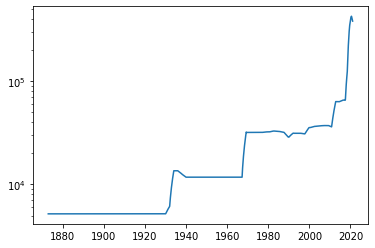

In [165]:
def movingAvg(dat_in,mask_size):
    avgData=np.zeros(len(dat_in))
    for i in range(mask_size,len(dat_in)):
        mean=0
        for j in range(mask_size):
            mean+=dat_in[i-j]
        mean=mean/mask_size
        avgData[i]=mean
    return avgData

# numbers_series = pd.Series(I[::-1])
# windows = numbers_series.rolling(2)
# moving_averages = windows.mean()
window=12*2
moving_averages = movingAvg(I[::-1],window)


plt.semilogy(dat[window:],moving_averages[window:],'-')
# plt.plot(dat[window:],moving_averages[window:],'-')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4d883e40-705b-4ee7-9326-895000a955f5' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>